In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
import copy
from sklearn.model_selection import train_test_split

import torchvision

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
cdata = torchvision.datasets.EMNIST(root='../13-CNN/emnist', split='letters', download=True)

In [3]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [4]:
print(cdata.classes)

print(str(len(cdata.classes)) + ' classes')

print('\nData size:')
print(cdata.data.shape)

# transform to 4D tensor for conv layers (and transform from int8 to float)
images = cdata.data.view([124800,1,28,28]).float()
print('\nTensor data:')
print(images.shape)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27 classes

Data size:
torch.Size([124800, 28, 28])

Tensor data:
torch.Size([124800, 1, 28, 28])


In [5]:
# brief aside: class 'N/A' doesn't exist in the data.
print( torch.sum(cdata.targets==0) )

# However, it causes problems in one-hot encoding...
torch.unique(cdata.targets)

tensor(0)


tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])

In [6]:
cdata.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [7]:
# so therefore we'll eliminate it and subtract 1 from the original

# remove the first class category
letterCategories = cdata.classes[1:]

# relabel labels to start at 0
labels = copy.deepcopy(cdata.targets)-1
print(labels.shape)

### 
print( torch.sum(labels==0) )
torch.unique(labels)

torch.Size([124800])
tensor(4800)


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

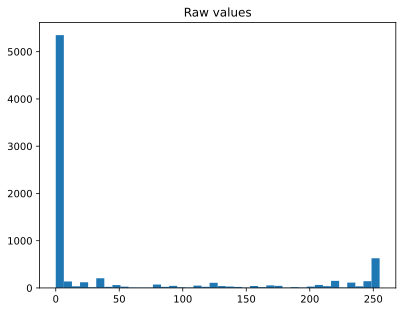

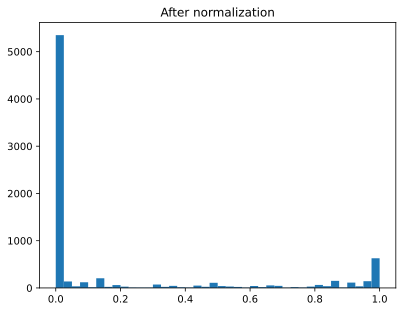

In [8]:
# next issue: do we need to normalize the images?
plt.hist(images[:10,:,:,:].view(1,-1).detach(),40);
plt.title('Raw values')
plt.show()

# pixels are in range of 0-255
# changing them to 0-1
images /= torch.max(images)

plt.hist(images[:10,:,:,:].view(1,-1).detach(),40);
plt.title('After normalization')
plt.show()

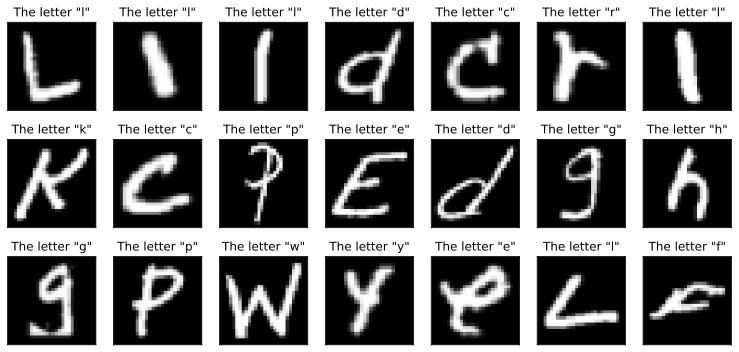

In [9]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):

  # pick a random pic
  whichpic = np.random.randint(images.shape[0])
  
  # extract the image and its target letter
  I = np.squeeze( images[whichpic,:,:] )
  letter = letterCategories[labels[whichpic]]
  
  # visualize
  ax.imshow(I.T,cmap='gray')
  ax.set_title('The letter "%s"'%letter)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [10]:
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [11]:
# check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([112320, 1, 28, 28])
torch.Size([112320])


In [12]:
class Model(nn.Module):
    def __init__ (self):
        super().__init__()

        self.enc = nn.Sequential(
            nn.Conv2d(1,64,3, padding=1), # output size: (28+2*1-3)/1 + 1 = 28
            nn.MaxPool2d(2), # output size: 28/2 = 14
            nn.BatchNorm2d(64), # number of channels in this layer
            nn.LeakyReLU(),
            nn.Dropout2d(0.1),

            nn.Conv2d(64,128,3, padding=1), # output size: (14+2*1-3)/1 + 1 = 14
            nn.MaxPool2d(2), # output size: 14/2 = 7
            nn.BatchNorm2d(128), # number of channels in this layer
            nn.LeakyReLU(),
            nn.Dropout2d(0.1),
        
            nn.Conv2d(128,256,3, padding=1), # output size: (7+2*1-3)/1 + 1 = 7
            nn.MaxPool2d(2), # output size: 7/2 = 3
            nn.BatchNorm2d(256), # number of channels in this layer
            nn.LeakyReLU(),
            nn.Dropout2d(0.1),

            nn.Flatten(),
            nn.Linear(3*3*256, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 26)
        )
    
    def forward(self, x):
        return self.enc(x)

In [13]:
def getModel():

    CNN = Model()

    lossFunction = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(CNN.parameters(), lr=0.001)

    return CNN, lossFunction, optimizer

In [14]:
# test model
CNN, lossFunction, optimizer = getModel()

X, y = next(iter(train_loader))
yHat = CNN(X)


# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossFunction(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)


Output size:
torch.Size([32, 26])
 
Loss:
tensor(3.2792, grad_fn=<NllLossBackward0>)


In [22]:
def trainModel(CNN, lossFunction, optimizer, train_loader, test_loader, epochs=5):

    trainLoss = torch.zeros(epochs)
    testLoss = torch.zeros(epochs)
    trainErr = torch.zeros(epochs)
    testErr = torch.zeros(epochs)

    CNN.to(device)

    for _ in range(epochs):
        print(' ')    
        print("Epoch: ", _)

        CNN.train()

        batchLoss = []
        batchErr = []

        for X, y in train_loader:

            X = X.to(device)
            y = y.to(device)

            yHat = CNN(X)

            loss = lossFunction(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            yHat = yHat.cpu()
            y = y.cpu()

            batchLoss.append(loss.item())

            batchErr.append(torch.mean((torch.argmax(yHat, axis=1)!=y).float()).item()*100)

        trainLoss[_] = np.mean(batchLoss)
        trainErr[_] = np.mean(batchErr)

        CNN.eval()

        X, Y = next(iter(test_loader))

        X = X.to(device)
        Y = Y.to(device)

        with torch.no_grad():
            pred = CNN(X)
            loss = lossFunction(pred, Y)

        pred = pred.cpu()
        Y = Y.cpu()

        testLoss[_] = loss.item()
        testErr[_] = torch.mean((torch.argmax(pred, axis=1)!=Y).float()).item()*100

    return trainLoss,testLoss,trainErr,testErr,CNN

In [23]:
# training on letters
CNN, lossFunction, optimizer = getModel()
trainLoss,testLoss,trainErr,testErr,net = trainModel(CNN, lossFunction, optimizer, train_loader, test_loader, 5)

 
Epoch:  0
 
Epoch:  1
 
Epoch:  2
 
Epoch:  3
 
Epoch:  4


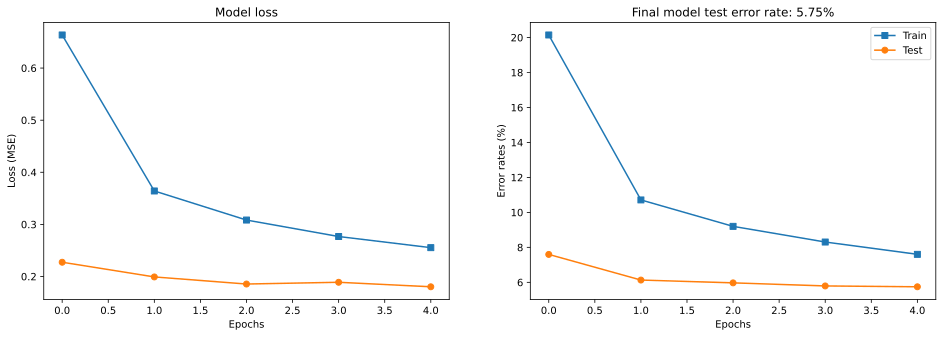

In [24]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()

In [18]:
dataNums = np.loadtxt(open('../00-Dataset/mnist_train_small.csv'), delimiter=',')

labelsNums = dataNums[:, 0]
dataNums = dataNums[:, 1:]

dataNormNums = dataNums/np.max(dataNums)

dataNormNums = dataNormNums.reshape(dataNormNums.shape[0], 1, 28, 28)

dataNormNums.shape

(20000, 1, 28, 28)

In [19]:
dataTNums = torch.tensor(dataNormNums).float()
labelsTNums = torch.tensor(labelsNums).long()

train_dataNums, test_dataNums, train_labelsNums, test_labelsNums = train_test_split(dataTNums, labelsTNums, train_size=0.9)

train_dataNums = TensorDataset(train_dataNums, train_labelsNums)
test_dataNums = TensorDataset(test_dataNums, test_labelsNums)

train_loaderNums = DataLoader(train_dataNums, batch_size=32, shuffle=True, drop_last=True)
test_loaderNums = DataLoader(test_dataNums, batch_size=test_dataNums.tensors[0].shape[0])

In [20]:
train_loaderNums.dataset.tensors[0].shape

torch.Size([18000, 1, 28, 28])

### training on numbers

In [25]:

CNNNums, lossFunctionNums, optimizerNums = getModel()

In [40]:
CNNNums
net.cpu() # bringing the letters net to cpu
print(CNNNums.enc[0].weight[0] - net.enc[0].weight[0])

for target, source in zip(CNNNums.named_parameters(), net.named_parameters()):
  target[1].data = copy.deepcopy( source[1].data )

print(CNNNums.enc[0].weight[0] - net.enc[0].weight[0])

tensor([[[ 0.1258, -0.3325, -0.2748],
         [-0.0543, -0.4557,  0.0811],
         [ 0.2081, -0.3725,  0.0401]]], grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], grad_fn=<SubBackward0>)


In [44]:
# changing the last liner layer in the CNNNums as that has to output 10 classes and letter nums outputs 26 classes

CNNNums.enc[22] = nn.Linear(64, 10)

In [50]:

trainLossNums,testLossNums,trainErrNums,testErrNums,netNums = trainModel(CNNNums, lossFunctionNums, optimizerNums, train_loaderNums, test_loaderNums, 1)

 
Epoch:  0


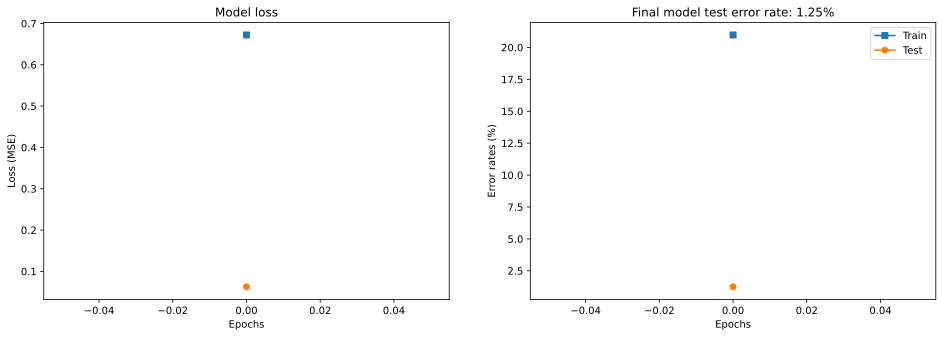

In [52]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLossNums,'s-',label='Train')
ax[0].plot(testLossNums,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErrNums,'s-',label='Train')
ax[1].plot(testErrNums,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErrNums[-1]:.2f}%')
ax[1].legend()

plt.show()

### one more experiment where convolution layers will be frozen and only linear layers will be trained

In [53]:
CNNNums2, lossFunctionNums2, optimizerNums2 = getModel()

In [54]:
CNNNums2
net.cpu() # bringing the letters net to cpu
print(CNNNums2.enc[0].weight[0] - net.enc[0].weight[0])

for target, source in zip(CNNNums2.named_parameters(), net.named_parameters()):
  target[1].data = copy.deepcopy( source[1].data )

print(CNNNums2.enc[0].weight[0] - net.enc[0].weight[0])

tensor([[[-0.0434, -0.0461,  0.2206],
         [-0.0718, -0.4237, -0.2431],
         [-0.0494,  0.1321, -0.0560]]], grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], grad_fn=<SubBackward0>)


In [55]:
CNNNums2.enc[22] = nn.Linear(64, 10)

In [64]:
CNNNums2.enc[1].weight[0].requires_grad

AttributeError: 'MaxPool2d' object has no attribute 'weight'

In [62]:
CNNNums2.enc 

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Dropout2d(p=0.1, inplace=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.01)
  (9): Dropout2d(p=0.1, inplace=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): LeakyReLU(negative_slope=0.01)
  (14): Dropout2d(p=0.1, inplace=False)
  (15): Flatten(start_

#### need to turn off requires_grad till layer 14

In [78]:
# switch off all layers except input
for i in range(15):
    if hasattr(CNNNums2.enc[i], 'weight'):
        print(CNNNums2.enc[i])
        CNNNums2.enc[i].weight.requires_grad = False

Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [80]:
for p in CNNNums2.named_parameters():
  print('Requires_grad status in layer %s: %s' %(p[0],p[1].requires_grad))

Requires_grad status in layer enc.0.weight: False
Requires_grad status in layer enc.0.bias: True
Requires_grad status in layer enc.2.weight: False
Requires_grad status in layer enc.2.bias: True
Requires_grad status in layer enc.5.weight: False
Requires_grad status in layer enc.5.bias: True
Requires_grad status in layer enc.7.weight: False
Requires_grad status in layer enc.7.bias: True
Requires_grad status in layer enc.10.weight: False
Requires_grad status in layer enc.10.bias: True
Requires_grad status in layer enc.12.weight: False
Requires_grad status in layer enc.12.bias: True
Requires_grad status in layer enc.16.weight: True
Requires_grad status in layer enc.16.bias: True
Requires_grad status in layer enc.19.weight: True
Requires_grad status in layer enc.19.bias: True
Requires_grad status in layer enc.22.weight: True
Requires_grad status in layer enc.22.bias: True


In [81]:
trainLossNums2,testLossNums2,trainErrNums2,testErrNums2,netNums2 = trainModel(CNNNums2, lossFunctionNums2, optimizerNums2, train_loaderNums, test_loaderNums, 1)

 
Epoch:  0


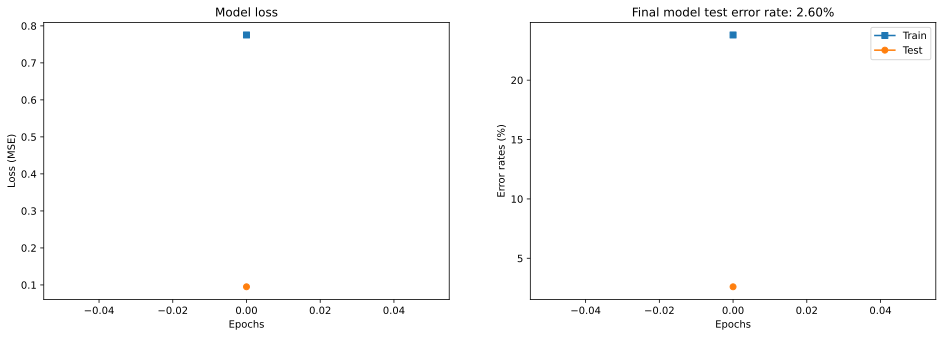

In [82]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLossNums2,'s-',label='Train')
ax[0].plot(testLossNums2,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErrNums2,'s-',label='Train')
ax[1].plot(testErrNums2,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErrNums2[-1]:.2f}%')
ax[1].legend()

plt.show()